# Analysis

This notebook provides an example of a full processing and analysis pipeline for a reduced dataset.

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [24]:
import logging
import os
import pprint
import matplotlib.pyplot as plt
from suite2p import default_ops, version
from IPython.utils import io

from constants import FPS, TAU_CA_DECAY, NEUROPIL_FACTOR, STIM_FRAME_INDEX, NTRIALS_PER_RUN
from logger import logger
from utils import *
from fileops import get_data_folders, get_output_equivalent, loadtif, savetif
from parsers import parse_experiment_parameters
from stackers import stack_tifs
from viewers import view, dualview
from s2putils import run_suite2p, get_suite2p_data
from plotters import plot_stack_summary, plot_run, plot_response
from filters import KalmanDenoiser

logger.setLevel(logging.INFO)

### General parameters

In [3]:
basedir = '../../data/raw/region1/'  # Root directory for raw data
overwrite = True  # overwrite behavior in case output files already exist (True, False, or '?')

## Tif merging

We start by merging individual tif files into a big stack tif file.

### Gather data folders

In [4]:
# Get raw list of subolders containing tifs 
datafolders = get_data_folders(basedir, exclude_patterns=['MIP', 'References'], include_patterns=['line3'])
logger.info(f'Identified data folders:\n{pprint.pformat(datafolders)}')

 14/10/2021 19:42:58: Identified data folders:
['../../data/raw/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749',
 '../../data/raw/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756',
 '../../data/raw/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748',
 '../../data/raw/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743',
 '../../data/raw/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752',
 '../../data/raw/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-746',
 '../../data/raw/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-745',
 '../../data/raw/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-750',
 '../../data/raw/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-744',
 '../../data/raw/region1/line3_100frames_100Hz_200ms_3.56Hz_02MPA_50DC-754',
 '../../data/raw/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_80DC-751',
 '../../data/raw/region1/line3_100frames_100Hz_200ms_3.56Hz_01MPA_50DC-755',
 '../../data/raw/region1/lin

### Select a particular data folder

In [5]:
datafolder = datafolders[0]
logger.info(f'Selected data folder:\n{datafolder}')

 14/10/2021 19:43:00: Selected data folder:
../../data/raw/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749


### Parse experiment parameters

In [6]:
exp_params = parse_experiment_parameters(os.path.basename(datafolder))
logger.info(f'Experiments parameters:\n{pprint.pformat(exp_params)}')

 14/10/2021 19:43:01: Experiments parameters:
{'???': 100.0,
 'DC': 60.0,
 'P': 8.0,
 'duration': 200.0,
 'fps': 3.56,
 'line': 'line3',
 'runID': 749,
 'trial_length': 100}


### Merge TIFs into stack

In [9]:
with io.capture_output() as captured:  # turning off warning upon TIF reading
    stack_fpath = stack_tifs(datafolder, overwrite=overwrite)
stack = loadtif(stack_fpath)

 14/10/2021 19:43:21: "/Users/tlemaire/Documents/data/stacked/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 14/10/2021 19:43:22: loaded (10, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/raw/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749_Cycle00001_Ch2_000001.ome.tif"
 14/10/2021 19:43:22: image ("line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749_Cycle00001_Ch2_000001.ome.tif") is corrupted (shape = (10, 256, 256)) -> ommitting first 9 frames
 14/10/2021 19:43:23: generated 1600-frames image stack
 14/10/2021 19:43:23: "/Users/tlemaire/Documents/data/stacked/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 14/10/2021 19:43:23: saving (1600, 256, 256) uint16 stack as "/Users/tlemaire/Documents/data/stacked/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif"...
 14/10/2021 19:43:24: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/

### Visualize stack

 14/10/2021 19:43:30: stack size: (1600, 256, 256)
 14/10/2021 19:43:30: rendering stack view...


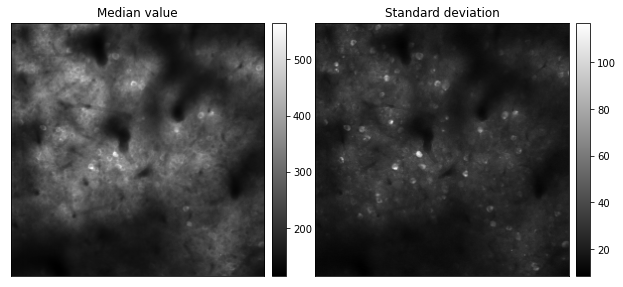

In [10]:
fig = plot_stack_summary(stack)
view(stack)

We notice a significant amount of Speckle noise in the acquired images, which must be removed.

## Kalman filtering

Let's now use our Kalman filter implementation to denoise the raw TIF stack.

We recall here that our modified Kalman implementation offers the advantages that
- wrong guesses of the initial variance will not prevent noise estimation but merely delay the fitting process.
- an initial baseline padding is used to absorb this fitting process.

Hence, we will fix here default parameters for the variance (`V = 0.05`) and padding length (`n = 10`) and focus our analysis on trying to find the optimal filter gain `G` that removes Speckle noise while mainting transient activity.

In [11]:
kd = KalmanDenoiser(V=0.05, npad=10)

### Low gain

In [12]:
kd.G = 0.5
dualview(stack, kd.filter(stack), title1='Raw', title2='Filtered', suptitle=kd)

 14/10/2021 19:43:46: constructing 10-frames baseline from 100-frames stack...
 14/10/2021 19:43:47: filtering 1600-frames stack with KalmanDenoiser(gain=0.5, var=0.05, npad=10)


100%|██████████| 1609/1609 [00:01<00:00, 1303.79it/s]


 14/10/2021 19:43:49: stack size: (1600, 256, 256)
 14/10/2021 19:43:49: rendering stacks view...


As we can see, the filtered stack retains Speckle noise.

### High gain

In [13]:
kd.G = 0.99
dualview(stack, kd.filter(stack), title1='Raw', title2='Filtered', suptitle=kd)

 14/10/2021 19:43:51: constructing 10-frames baseline from 100-frames stack...
 14/10/2021 19:43:52: filtering 1600-frames stack with KalmanDenoiser(gain=0.99, var=0.05, npad=10)


100%|██████████| 1609/1609 [00:01<00:00, 1422.94it/s]


 14/10/2021 19:43:54: stack size: (1600, 256, 256)
 14/10/2021 19:43:54: rendering stacks view...


This time the filter also suppressed some relevant transient activity. 

### Optimal gain

In [14]:
kd.G = 0.8
filtered_stack = kd.filter(stack)
dualview(stack, filtered_stack, title1='Raw', title2='Filtered', suptitle=kd)

 14/10/2021 19:43:54: constructing 10-frames baseline from 100-frames stack...
 14/10/2021 19:43:55: filtering 1600-frames stack with KalmanDenoiser(gain=0.8, var=0.05, npad=10)


100%|██████████| 1609/1609 [00:01<00:00, 1455.21it/s]


 14/10/2021 19:43:57: stack size: (1600, 256, 256)
 14/10/2021 19:43:57: rendering stacks view...


Looks like the optimal gain is somewhere around 0.8.

### Save denoised data

In [18]:
filtered_stack_fpath = get_output_equivalent(stack_fpath, 'stacked', 'filtered')
savetif(filtered_stack_fpath, filtered_stack, overwrite=overwrite)

 14/10/2021 19:44:29: "/Users/tlemaire/Documents/data/filtered/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 14/10/2021 19:44:29: saving (1600, 256, 256) uint16 stack as "/Users/tlemaire/Documents/data/filtered/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif"...


### Define suite2p options

In [19]:
# Custom options
myops = {
    'tau': TAU_CA_DECAY,  # timescale mof the sensor (in our case GCaMP6s)
    'fs': FPS,  # sampling rate (per plane)
    'reg_tif': True,  # whether or not to write the registered binary to tiff files
    'nonrigid': True,  # whether or not to perform non-rigid registration, which splits the field of view into blocks and computes registration offsets in each block separately.
    # 'denoise': True,  # ???
}

ops = default_ops()  # get default run options
# ops.update(myops)  # update with personal options
logger.info(f'Suite2p {version} with run options:\n{pprint.pformat(ops)}')

 14/10/2021 19:44:32: Suite2p 0.10.2 with run options:
{'1Preg': False,
 'align_by_chan': 1,
 'allow_overlap': False,
 'anatomical_only': 0,
 'aspect': 1.0,
 'baseline': 'maximin',
 'batch_size': 500,
 'bidi_corrected': False,
 'bidiphase': 0,
 'block_size': [128, 128],
 'bruker': False,
 'bruker_bidirectional': False,
 'cellprob_threshold': 0.0,
 'chan2_thres': 0.65,
 'classifier_path': 0,
 'combined': True,
 'connected': True,
 'delete_bin': False,
 'denoise': False,
 'diameter': 0,
 'do_bidiphase': False,
 'do_registration': 1,
 'fast_disk': [],
 'flow_threshold': 1.5,
 'force_refImg': False,
 'force_sktiff': False,
 'frames_include': -1,
 'fs': 10.0,
 'functional_chan': 1,
 'h5py': [],
 'h5py_key': 'data',
 'high_pass': 100,
 'ignore_flyback': [],
 'inner_neuropil_radius': 2,
 'keep_movie_raw': False,
 'lam_percentile': 50.0,
 'look_one_level_down': False,
 'max_iterations': 20,
 'max_overlap': 0.75,
 'maxregshift': 0.1,
 'maxregshiftNR': 5,
 'mesoscan': False,
 'min_neuropil_pixel

### Run suite2p

In [23]:
# Define input dataset
inputdir, _ = os.path.split(filtered_stack_fpath)
db = {'data_path': [inputdir]}
# Run suite2p
opsend = run_suite2p(ops=ops, db=db, overwrite=overwrite)

/Users/tlemaire/Documents/data/filtered/region1/suite2p/plane0
 14/10/2021 19:45:22: suite2p output files already exist in "/Users/tlemaire/Documents/data/filtered/region1/suite2p/plane0"
{'data_path': ['/Users/tlemaire/Documents/data/filtered/region1']}
FOUND BINARIES AND OPS IN ['/Users/tlemaire/Documents/data/filtered/region1/suite2p/plane0/ops.npy']
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not running registration, plane already registered
binary path: /Users/tlemaire/Documents/data/filtered/region1/suite2p/plane0/data.bin
NOTE: applying default /Users/tlemaire/.suite2p/classifiers/classifier_user.npy
----------- ROI DETECTION
Binning movie in chunks of length 10
Binned movie [150,254,254] in 0.44 sec.
NOTE: estimated spatial scale ~6 pixels, time epochs 1.00, threshold 5.00 
0 ROIs, score=48.61
1000 ROIs, score=5.32
Detected 1192 ROIs, 5.42 sec
After removing overlaps, 988 ROIs remain
----------- Total 7.55 sec.
----------- EXTRACTION
Masks created, 0.75 sec.


/opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'cell_ipix' of function 'matmul_traces'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/suite2p/extraction/extract.py", line 105:
@njit(parallel=True)
def matmul_traces(Fi, data, cell_ipix, cell_lam):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'cell_lam' of function 'matmul_traces'.

For more information visit https://numba.pydata.org/numba-doc/latest/

Extracted fluorescence from 988 ROIs in 1600 frames, 4.04 sec.
----------- Total 4.92 sec.
----------- CLASSIFICATION
['skew', 'npix_norm', 'compact']
----------- Total 0.04 sec.
----------- SPIKE DECONVOLUTION
----------- Total 0.12 sec.
Plane 0 processed in 12.65 sec (can open in GUI).
total = 12.68 sec.
TOTAL RUNTIME 12.68 sec


### Inspect suite2p output metrics

In [25]:
print(opsend.keys())

dict_keys(['suite2p_version', 'look_one_level_down', 'fast_disk', 'delete_bin', 'mesoscan', 'bruker', 'bruker_bidirectional', 'h5py', 'h5py_key', 'nwb_file', 'nwb_driver', 'nwb_series', 'save_path0', 'save_folder', 'subfolders', 'move_bin', 'nplanes', 'nchannels', 'functional_chan', 'tau', 'fs', 'force_sktiff', 'frames_include', 'multiplane_parallel', 'ignore_flyback', 'preclassify', 'save_mat', 'save_NWB', 'combined', 'aspect', 'do_bidiphase', 'bidiphase', 'bidi_corrected', 'do_registration', 'two_step_registration', 'keep_movie_raw', 'nimg_init', 'batch_size', 'maxregshift', 'align_by_chan', 'reg_tif', 'reg_tif_chan2', 'subpixel', 'smooth_sigma_time', 'smooth_sigma', 'th_badframes', 'norm_frames', 'force_refImg', 'pad_fft', 'nonrigid', 'block_size', 'snr_thresh', 'maxregshiftNR', '1Preg', 'spatial_hp', 'spatial_hp_reg', 'spatial_hp_detect', 'pre_smooth', 'spatial_taper', 'roidetect', 'spikedetect', 'anatomical_only', 'cellprob_threshold', 'flow_threshold', 'sparse_mode', 'diameter', 

### Load suite2p ouput and extract fluorescence data

In [26]:
data = get_suite2p_data(inputdir)
F = data['F'] - NEUROPIL_FACTOR * data['Fneu']


### Plot timecourses of absolute fluorescence

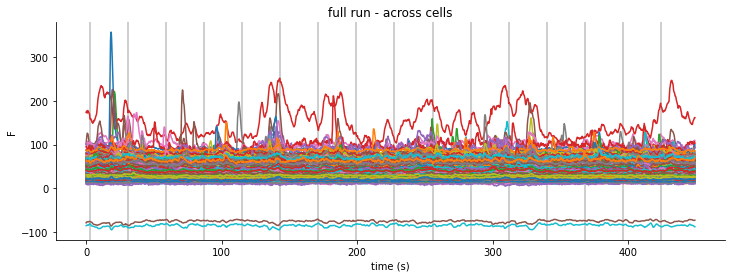

In [27]:
fig = plot_run(F, FPS, 'F', title='across cells', mark_stim=True)

### Compute baseline fluorescence data

By applying a 15-frames wide moving average window on the raw fluorescence profiles

In [28]:
F0 = get_F_baseline(F)

Let's look at the baseline estimation results on a particular cell

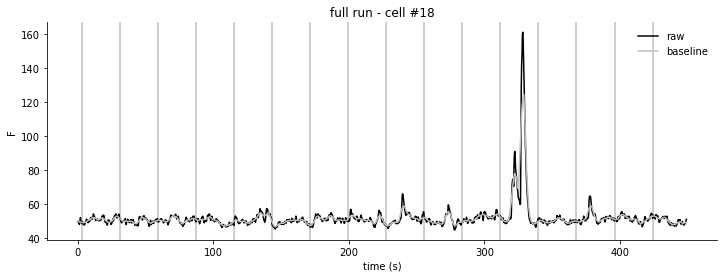

In [29]:
cell_id = 18
fig = plot_run([F[cell_id], F0[cell_id]], FPS, 'F', label=['raw', 'baseline'], color=['k', 'silver'], title=f'cell #{cell_id}', mark_stim=True)

### Compute relative fluorescence data

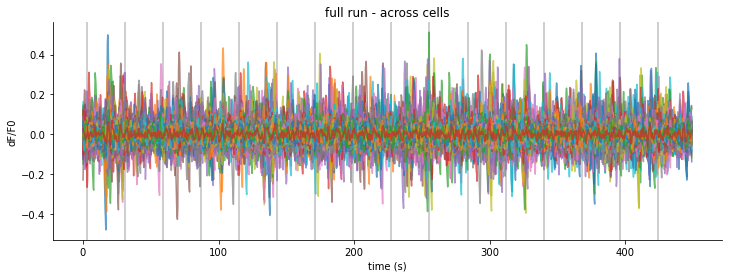

In [30]:
dFF = (F - F0) / F0
fig = plot_run(dFF, FPS, 'dF/F0', title='across cells', mark_stim=True, alpha=0.7)

### Split the data into separate trials 

In [31]:
dFF_pertrial = separate_trials(dFF, NTRIALS_PER_RUN)

### Compute average response across trials

In [32]:
dFF_trialavg = np.mean(dFF_pertrial, axis=1)

### Plot Calcium transients for a particular cell

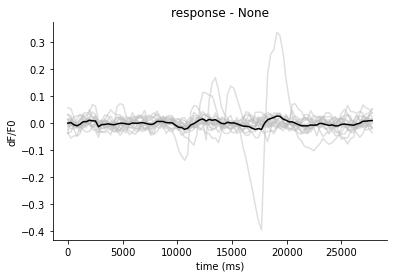

In [33]:
fig = plot_response(dFF_pertrial[cell_id], FPS, avgmode=True, tbounds=None)